In [1]:
import glob
import h5py
import numpy as np
from pycbc import conversions
from pycbc.cosmology import redshift
from matplotlib import pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams['font.size'] = 14

In [3]:
def extract_plot_data(postfiles):
    outdata = {'mchirp': [], 'mchirp_src': [], 'q': [], 'snr': []}
    for f in postfiles:
        # extract posterior samples and injected values
        with h5py.File(f, 'r') as fp:
            samples = {p: v[:] for p, v in fp['samples'].items()}
            injvals = {p: v for p, v in fp['injections'].attrs.items()
                       if isinstance(v, float)}
            lognl = fp['samples'].attrs['lognl']
        # calculate max SNR
        snr = np.sqrt(2 * (samples['loglikelihood'].max() - lognl))
        # convert injected values to mchirp, q
        injvals['mchirp'] = conversions.mchirp_from_mass1_mass2(
            injvals['mass1'], injvals['mass2'])
        injvals['q'] = conversions.q_from_mass1_mass2(
            injvals['mass1'], injvals['mass2'])
        # convert chirp masses to source-frame
        samples['mchirp_src'] = samples['mchirp'] / (1 + redshift(samples['distance']))
        injvals['mchirp_src'] = injvals['mchirp'] / (1 + redshift(injvals['distance']))
        # store param stats
        mchirp_data = tuple([np.mean(samples['mchirp']), np.std(samples['mchirp'])])
        mchirp_src_data = tuple([np.median(samples['mchirp_src']), injvals['mchirp_src']])
        q_data = tuple([np.mean(samples['q']), np.std(samples['q'])])
        outdata['mchirp'].append(mchirp_data)
        outdata['mchirp_src'].append(mchirp_src_data)
        outdata['q'].append(q_data)
        outdata['snr'].append(snr)
    # cast to arrays
    for p, v in outdata.items():
        outdata[p] = np.array(v)
    return outdata

In [4]:
bnsfiles = glob.glob('bns_posteriors/*.hdf')
nsbhfiles = glob.glob('nsbh_posteriors/*.hdf')

bns_data = extract_plot_data(bnsfiles)
nsbh_data = extract_plot_data(nsbhfiles)

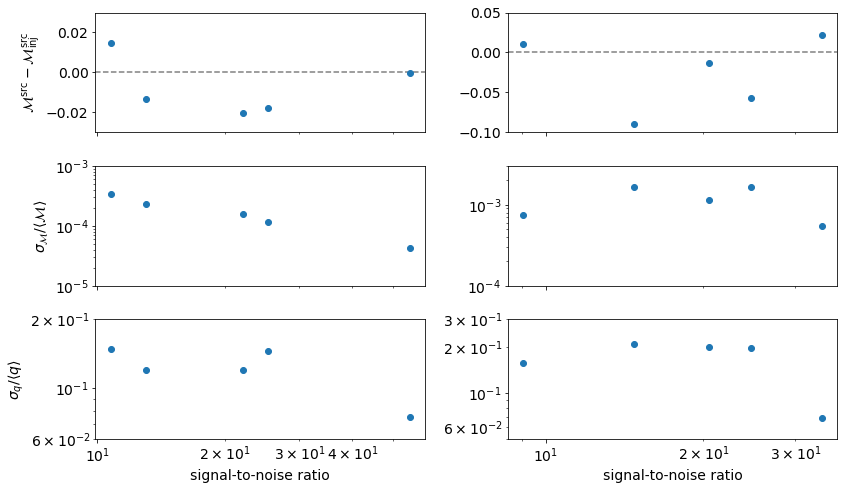

In [5]:
fig, ax = plt.subplots(3, 2, figsize=(12, 7))
ax[0, 0].scatter(bns_data['snr'],
                 bns_data['mchirp_src'][:, 0] - bns_data['mchirp_src'][:, 1])
ax[0, 1].scatter(nsbh_data['snr'],
                 nsbh_data['mchirp_src'][:, 0] - nsbh_data['mchirp_src'][:, 1])
ax[1, 0].scatter(bns_data['snr'],
                 bns_data['mchirp'][:, 1] / bns_data['mchirp'][:, 0])
ax[1, 1].scatter(nsbh_data['snr'],
                 nsbh_data['mchirp'][:, 1] / nsbh_data['mchirp'][:, 0])
ax[2, 0].scatter(bns_data['snr'],
                 bns_data['q'][:, 1] / bns_data['q'][:, 0])
ax[2, 1].scatter(nsbh_data['snr'],
                 nsbh_data['q'][:, 1] / nsbh_data['q'][:, 0])

ylabels = [r'$\mathcal{M}^{\mathrm{src}}-\mathcal{M}_{\mathrm{inj}}^{\mathrm{src}}$',
           r'$\sigma_{\mathcal{M}}/\langle\mathcal{M}\rangle$',
           r'$\sigma_{q}/\langle q \rangle$']
ylims = [(-3e-2, 3e-2), (-1e-1, 5e-2),
         (1e-5, 1e-3), (1e-4, 3e-3),
         (6e-2, 2e-1), (5e-2, 3e-1)]
for a, yl in zip(ax.ravel(), ylims):
    a.set(xscale='log', ylim=yl)
for a in ax[0, :].ravel():
    a.axhline(0, ls='dashed', color='grey', zorder=0)
for a in ax[0:2, :].ravel():
    a.tick_params(which='both', labelbottom=False)
for a in ax[1:, :].ravel():
    a.set(yscale='log')
for a in ax[2, :].ravel():
    a.set(xlabel='signal-to-noise ratio')
for a, l in zip(ax[:, 0].ravel(), ylabels):
    a.set(ylabel=l)
plt.tight_layout()
plt.show()